Импорт всего и вся

In [203]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, balanced_accuracy_score, f1_score, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, chi2

from sklearn import svm

Берем датасет из репы

In [175]:
!git clone https://github.com/zayservl/AI_innopolis_arch.git

fatal: destination path 'AI_innopolis_arch' already exists and is not an empty directory.


In [192]:
df_data = pd.read_csv('/content/AI_innopolis_arch/diabetes.csv')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [177]:
df_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [178]:
df_data.isna().apply(lambda x: x.sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Подготовка данных

Составляем из данных необходимого вида массивы. Пробовал StandartScaler для kNN - хороших резуоттатов не дало.

In [193]:
y_data = df_data.pop('Outcome')
# scaler = StandardScaler().fit(df_data)
x_data = df_data #scaler.transform(df_data)#Стандартизация хороших результатов не показала
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.3, random_state=42)

kNN тестируем для следующего набора [5, 10, 15, 20, 25]

In [194]:
knn_acc = []
knn_N = [5, 10, 15, 20, 25] #np.array([i for i in range(1,100, 2)])#
for n in knn_N:
  neigh = KNeighborsClassifier(n_neighbors=n)
  neigh.fit(x_train, y_train)
  y_pred = neigh.predict(x_test)
  class_report = classification_report(y_test, y_pred)
  knn_acc.append(accuracy_score(y_test, y_pred))
  print(f"Class_report for {n} neighborhoods:\n {class_report}")
  print("#"*20)

Class_report for 5 neighborhoods:
               precision    recall  f1-score   support

           0       0.75      0.81      0.78       349
           1       0.58      0.50      0.54       189

    accuracy                           0.70       538
   macro avg       0.67      0.65      0.66       538
weighted avg       0.69      0.70      0.69       538

####################
Class_report for 10 neighborhoods:
               precision    recall  f1-score   support

           0       0.72      0.88      0.79       349
           1       0.62      0.37      0.46       189

    accuracy                           0.70       538
   macro avg       0.67      0.62      0.63       538
weighted avg       0.68      0.70      0.68       538

####################
Class_report for 15 neighborhoods:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78       349
           1       0.59      0.42      0.49       189

    accuracy                     

Ориентируемся на метрику f1 и точность. Видим, что на 25 соседях - самая лучшая метрика. Визуализируем это.

Text(0, 0.5, 'accuracy')

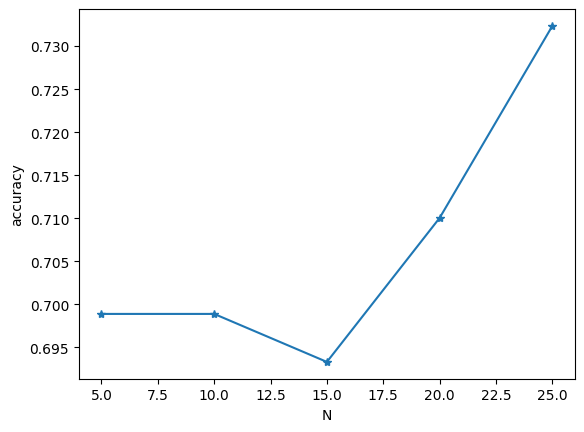

In [195]:
plt.plot(knn_N, knn_acc, marker = "*")
plt.xlabel('N')
plt.ylabel('accuracy')

Так как данные многомерны, то напрямую визуализировать у нас не получится, так что будем выкручиваться тем, что визуализировать в проекциях на каждую плоскость.

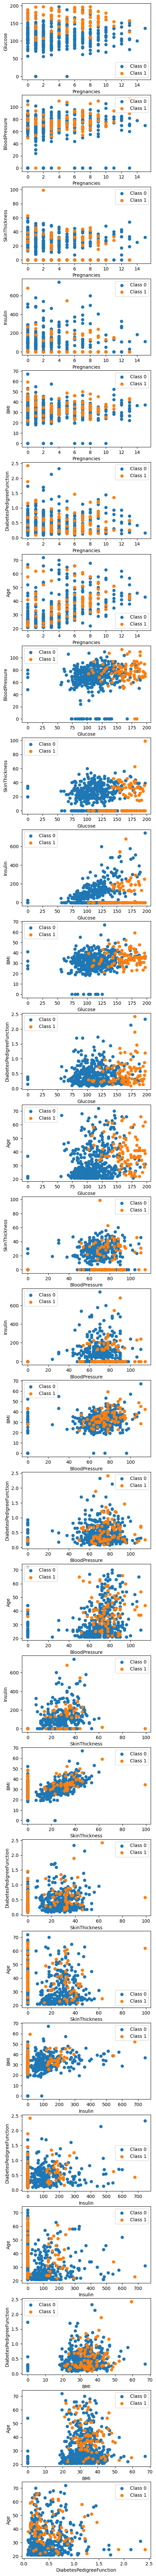

In [196]:
def plot_classification(pd_data, classes):

  columns = pd_data.columns.values
  pairs = []
  for i in range(len(columns)):
    for j in range(i+1, len(columns)):
      pairs.append([columns[i], columns[j]])

  figure, axis = plt.subplots(len(pairs), figsize = (5,100))
  for id, pair in enumerate(pairs):
    data=np.c_[pd_data[pair[0]],pd_data[pair[1]],classes]
    for i in [0,1]:
      axis[id].scatter(
          data[np.where(data[:,2 ] == i)][:,0],
          data[np.where(data[:,2 ] == i)][:,1],
          label = f"Class {i}"
          )
      axis[id].legend()
      axis[id].set_xlabel(f'{pair[0]}')
      axis[id].set_ylabel(f'{pair[1]}')


knn_best = KNeighborsClassifier(n_neighbors=25).fit(x_train, y_train)
plot_classification(x_test, knn_best.predict(x_test))

Задачка построения линейной регрессии для определения уровня инсулина. Готовим данные. Так как они разнородны, а для линейной регрессии это важно, то нормализуем.

In [210]:
df_data = pd.read_csv('/content/AI_innopolis_arch/diabetes.csv')[
    ['SkinThickness','BMI', 'Insulin']
    ]

data_scaled = StandardScaler().fit_transform(df_data)

y_data = data_scaled[:, 2]
x_data = data_scaled[:, 0:2]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.3, random_state=42)
print(f"len train {len(y_train)}\nlen test {len(y_test)}")

len train 230
len test 538


Построим линейную регрессию и оценим точность по r2 и среднеквадратичной разности

In [211]:
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

print(f"MSE: {round(mse,2)}")
print(f"R2 score: {round(reg.score(x_test, y_test),2)}")

MSE: 0.84
R2 score: 0.18


Видно, что результат очень плох. Попробуем понять в чем же дело. Для этого построим гистограмму результата регрессии и тестового набора.

(array([ 79.,  79.,  94., 183.,  85.,  17.,   0.,   0.,   0.,   1.]),
 array([-7.79445192e-01, -5.19936117e-01, -2.60427041e-01, -9.17965780e-04,
         2.58591110e-01,  5.18100185e-01,  7.77609260e-01,  1.03711834e+00,
         1.29662741e+00,  1.55613649e+00,  1.81564556e+00]),
 <BarContainer object of 10 artists>)

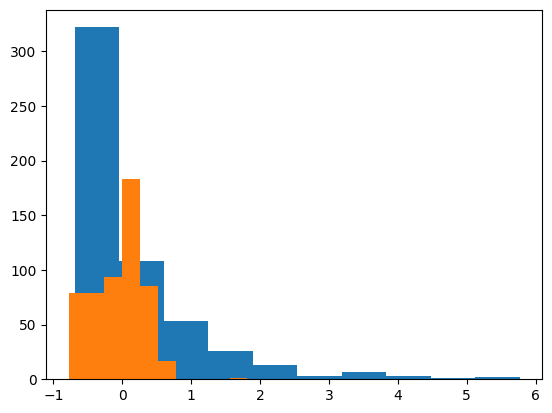

In [212]:
plt.hist(y_test)
plt.hist(y_pred)

Мы уже тут видим, что линейная модель не может предсказать нужный нам результат. Взглянем на данные - сразу вижно, что построить линейную модель в таком облаке точке очень нетривиальная задача и такой класс моделей тут не подходит

Text(0, 0.5, 'BMI')

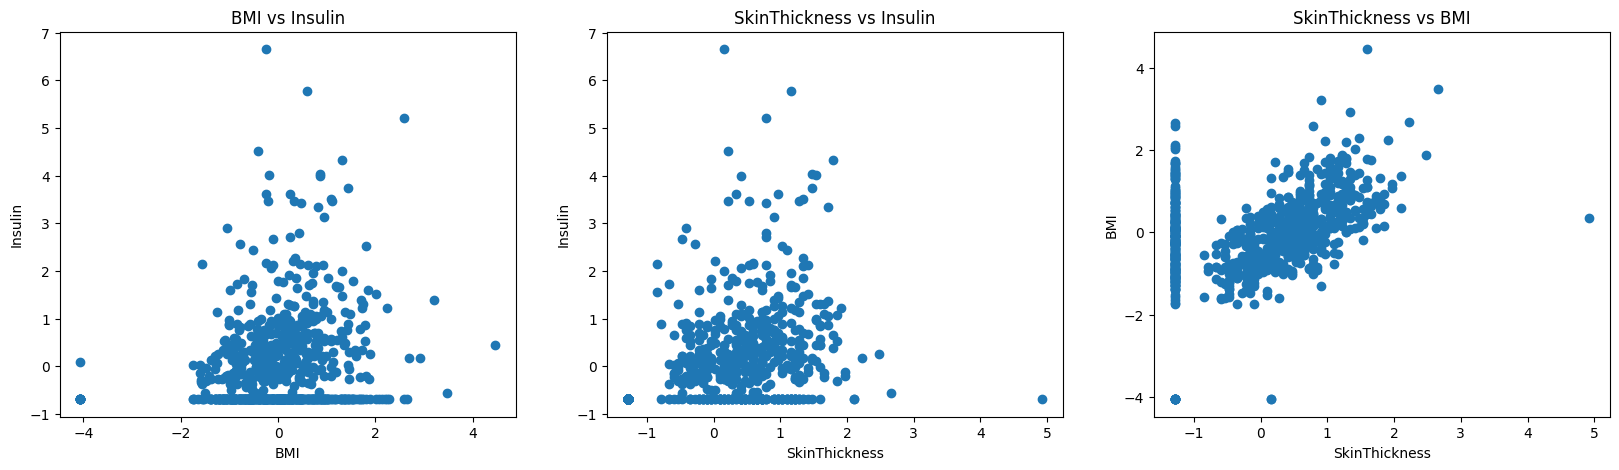

In [213]:
fig, axis = plt.subplots(1, 3, figsize = (20,5))
axis[0].scatter(data_scaled[:,1], data_scaled[:,2])
axis[0].set_title('BMI vs Insulin')
axis[0].set_xlabel('BMI')
axis[0].set_ylabel('Insulin')

axis[1].scatter(data_scaled[:,0], data_scaled[:,2])
axis[1].set_title('SkinThickness vs Insulin')
axis[1].set_xlabel('SkinThickness')
axis[1].set_ylabel('Insulin')

axis[2].scatter(data_scaled[:,0], data_scaled[:,1])
axis[2].set_title('SkinThickness vs BMI')
axis[2].set_xlabel('SkinThickness')
axis[2].set_ylabel('BMI')

In [214]:
print("y=b+a1*x1+a2*x2")
print(f"A1, A2 coefs: {reg.coef_}")
print(f"B coef: {reg.intercept_}")

y=b+a1*x1+a2*x2
A1, A2 coefs: [ 0.38424573 -0.09351634]
B coef: -0.04342589879991668


Вывод: Данные между собой не имеют корреляции, применение линейной регрессии - дело гиблое.

Попробуем решить задачу прогноза беременности по остальным данным. Для этого приведем немного данные в нужный вид.

In [242]:
df_data = pd.read_csv('/content/AI_innopolis_arch/diabetes.csv')

df_data.loc[df_data["Pregnancies"] == 0, "IsPregnancies"] = False
df_data.loc[df_data["Pregnancies"] > 0, "IsPregnancies"] = True

x_data = df_data.drop(["Pregnancies"], axis = 1)

y_data = x_data.pop('IsPregnancies').astype(bool)


Для интереса сравним SVM и DTC с примененим GridSearch, который одновременно и будет искать нам оптимальные параметры модельки и оценит качество обучения.

In [243]:
DTC_param = {
    'criterion':['gini','entropy'],
    'max_depth': list(range(4,101,2))
    }
SVC_param = {
    'C': list([10**i for i in range(-3,4)]),
    'kernel': ['linear', 'rbf']}


В качестве метрики будем искользовать balanced accurancy, так как соотношение беременных к небеременным в исследовании составляеи 1 к 6, что говорит о дисбалансе выборки.
Разделение на обучающую и тестовую выборку берем равным 1\5


In [229]:
print(f"Беременные {np.sum(y_data)}\nНе беременные {len(y_data) - np.sum(y_data)}")

Беременные 657
Не беременные 111


Всего для деревьев хватает глубины 16 и точность модели низкая - 0.57

In [246]:
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), DTC_param, cv=5, scoring='balanced_accuracy')
clf.fit(x_data, y_data)
print(f"Best score: {np.round(clf.best_score_,2)}\nBest Parametrs: {clf.best_params_}")

Best score: 0.57
Best Parametrs: {'criterion': 'gini', 'max_depth': 16}


Для SVC важно стандартизировать данные, что мы и делаем в начале.

In [236]:
x_data_scaled = pd.DataFrame(
    StandardScaler().fit_transform(x_data),
    columns = x_data.columns)

clf = GridSearchCV(svm.SVC(random_state=42), SVC_param, cv=5, scoring='balanced_accuracy')
clf.fit(x_data_scaled, y_data)
print(f"Best score: {np.round(clf.best_score_,2)}\nBest Parametrs: {clf.best_params_}")


Best score: 0.55
Best Parametrs: {'C': 10, 'kernel': 'rbf'}


Видно, что беременность мы предсказываем плохо по таким данным.

Попробуем CatBoost

In [255]:
!pip install catboost

In [259]:
from catboost import CatBoostClassifier

CAT_param = {'learning_rate': [0.03, 0.1, 0.5],
            'depth': [4, 6, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9]
             }

clf = GridSearchCV(
    CatBoostClassifier(iterations=50,random_seed=42, verbose=False),
    CAT_param,
    cv=5,
    scoring= 'balanced_accuracy'
    )
clf.fit(x_data, np.int32(y_data))
print(f"Best score: {np.round(clf.best_score_,2)}\nBest Parametrs: {clf.best_params_}")

Best score: 0.56
Best Parametrs: {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.5}


Даже с CatBoost мы не достигли желаемой точности. Видимо, требуется дальнейая работа с данными.